# Self-Driving Car Engineer Nanodegree

## Project 4: Advanced Lane Finding

### This project will create a software pipeline to detect lane lines in a video stream.

## Project Goals / Deliverables
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Load Libraries

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
device: 0, name: GeForce GT 730M, pci bus id: 0000:01:00.0 /gpu:0

Loading... Project 5: Vehicle Detection and Tracking

The scikit-learn version is 0.17.1.
3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


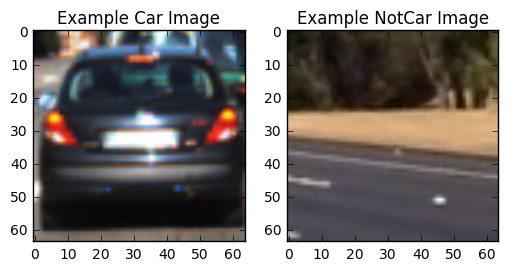

Number of Cars: 8792
Number of NotCars: 8968 

Shape: (64, 64, 3)
Data Type: float32
Average Value 0.291191
Feature Extraction...
70.23 Seconds for Feature Extraction...
Done!

X Shape: (17760, 2052)
scaled_X Shape: (17760, 2052)
Feature Selection...
Fitting estimator with 2052 features.
Fitting estimator with 1952 features.
Fitting estimator with 1852 features.
Fitting estimator with 1752 features.
Fitting estimator with 1652 features.
Fitting estimator with 1552 features.
Fitting estimator with 1452 features.
Fitting estimator with 1352 features.
Fitting estimator with 1252 features.
Fitting estimator with 1152 features.
Fitting estimator with 1052 features.
Fitting estimator with 952 features.
Fitting estimator with 852 features.
Fitting estimator with 752 features.
Fitting estimator with 652 features.
Fitting estimator with 552 features.
Fitting estimator with 452 features.
Fitting estimator with 352 features.
Fitting estimator with 252 features.
Fitting estimator with 152 features

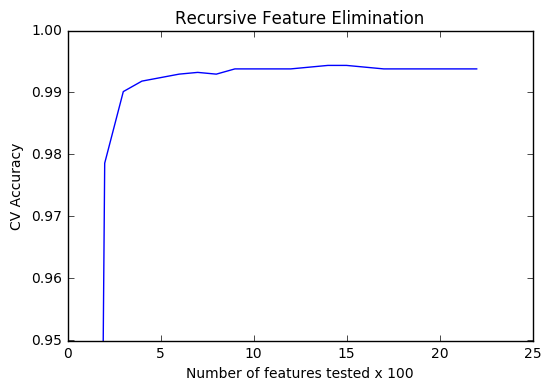


Max CV Score:  0.994

X Shape: (17760, 2052)
X_New Shape: (17760, 1252) 

43.74 Seconds for Feature Selection...
Done!
Training set: (14208, 1252)
Testing set: (3552, 1252) 

0.71 Seconds to train SVC...

Train Accuracy of SVC =  0.998
Test Accuracy of SVC =  0.9952


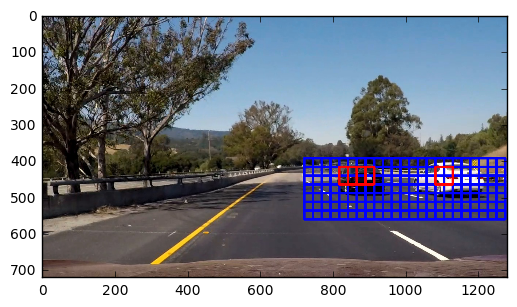

118.81 Seconds to Load Project 5: Vehicle Detection and Tracking...
Done!


In [1]:
import os
import cv2
import time
import glob
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import sys
print(sys.version)

from tensorflow.python.client import device_lib
print (device_lib.list_local_devices()[1].physical_device_desc,device_lib.list_local_devices()[1].name)

if (1): # import Projec 5: Vehicle Detection and Trakcing
    print ("\nLoading... Project 5: Vehicle Detection and Tracking\n")
    t=time.time()
    import P5_10 as P5
    t2 = time.time()
    print (round(t2-t, 2), 'Seconds to Load Project 5: Vehicle Detection and Tracking...')
    print ('Done!')

## Create Folders --> Save Output Images

In [2]:
def make_output_dir():
    if not os.path.exists('input_images/'): os.mkdir('input_images')

    dir_list = ['video_4','video_5','video_6']
    for directory in dir_list:
        if not os.path.exists('input_images/'+directory):
            os.mkdir('input_images/'+directory)

    dir_list = ['test_images','video_4','video_5','video_6','corners_found']
    for directory in dir_list:
        if not os.path.exists('output_images/'+directory):
            os.mkdir('output_images/'+directory)   
    return None

if (1): make_output_dir()

## Camera Calibration --> Distortion Correction
Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect. Distortion actually changes what the shape and size of these 3D objects appear to be. So, the first step in analyzing camera images, is to undo this distortion so that you can get correct and useful information out of them.

Radial Distortion is the most common type of distortion. This distortion occurs when light rays are bending too much or to little at the edges of the lenses. This makes the edge of pictures appear more or less curvy than they really are in reality. 

Tangential Distortion occurs when a camera's lens is not aligned perfectly parallel to the imaging plane. This makes an image look tilted so that some objects appear farther away or closer than they actually are in reality.

Camera Calibration maps 3D points (objpoints) in the Real World to 2D points (imgpoints) in the Image Plane. This can be done with a known grid pattern such as a chessboard. This process uses multiple images of chessboards from a variety of camera angles and distances. The images are used as inputs to the cv2.findChessboardCorners function which then returns the corners found on the chessboards. The grid pattern in the 3D Real World (objpoints) and the corners found in the 2D Image World (imgpoints) are then used as inputs to the cv2.calibrateCamera function which returns Camera Calibration Values (mtx, dist). These values along with the original image (with distortion) are inputs to the cv2.undistort function which returns the undistorted image. 

These images have now been corrected for Radial Distortion and Tangential Distortion.

In [3]:
def camera_calibration(image_dir, filename, nx, ny):
    # arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space (x,y,z): (0,0,0) to (7,5,0)
    imgpoints = [] # 2D points in image plane

    # prepare object points ==> number of inside corners in x and y
    objp = np.zeros((nx*ny,3), np.float32) # 8 x 6 chessboard grid, (x,y,z) coordinates
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

    images = glob.glob(image_dir + '/' + filename + '*.jpg') 

    for idx, fname in enumerate(images):
        img = mpimg.imread(fname) # Note: mpimg.imread() reads in RGB, cv2.imread() reads in BGR
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # mpimg.imread() use RGB2GRAY, cv2.imread() use BGR2GRAY
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True: # if corners are found, add object points, image points
            imgpoints.append(corners)
            objpoints.append(objp) # Note: Same for all images, since these represent the real chessboard
    
            # draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)           
            write_name = 'corners_found'+str(idx)+'.jpg'
            cv2.imwrite('output_images/corners_found/'+write_name, img)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()

    # calibrate camera given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[0:2],None,None)

    # save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    if not os.path.exists('camera_cal/corners_found'): os.mkdir('camera_cal/corners_found')
    pickle.dump(dist_pickle, open('./camera_cal/calibration_pickle.p','wb'))
    return mtx, dist

def get_camera_calibration_values():
    t = time.time()
    # check to see if camera is already calibrated, if not.. then calibrate!
    if (1) and os.path.exists('camera_cal/calibration_pickle.p'):
        print ('Loading camera calibration values... \n')
        dist_pickle = pickle.load(open('camera_cal/calibration_pickle.p','rb'))
        mtx, dist = dist_pickle['mtx'], dist_pickle['dist']
    else:
        print ('Calibrating Camera...\n')
        mtx, dist = camera_calibration(image_dir = 'camera_cal', filename = 'calibration', nx = 9, ny = 6)
    t2 = time.time()
    print (round(t2-t, 2), 'Seconds to get Camera Calibration values..')
    print ('Done!')
    return mtx, dist

Loading camera calibration values... 

0.0 Seconds to get Camera Calibration values..
Done!


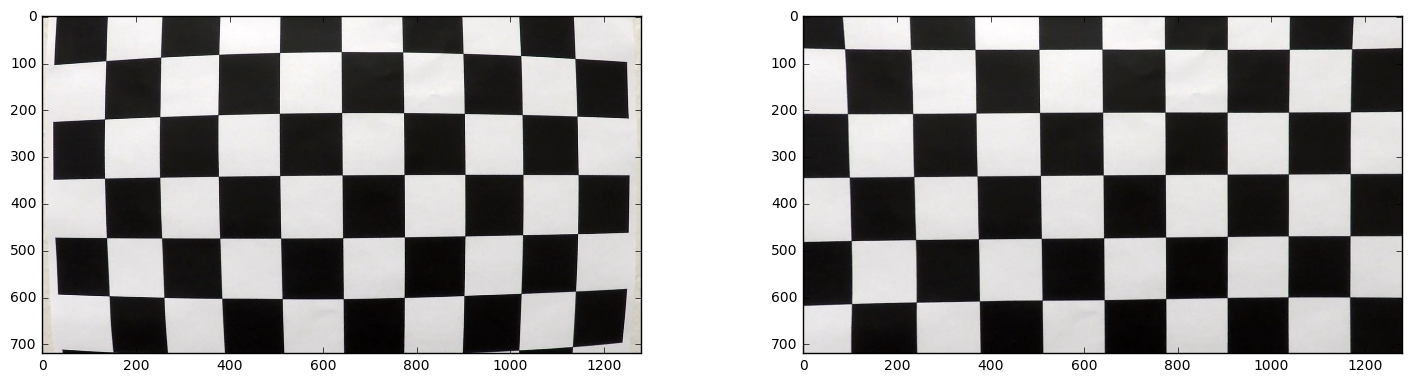

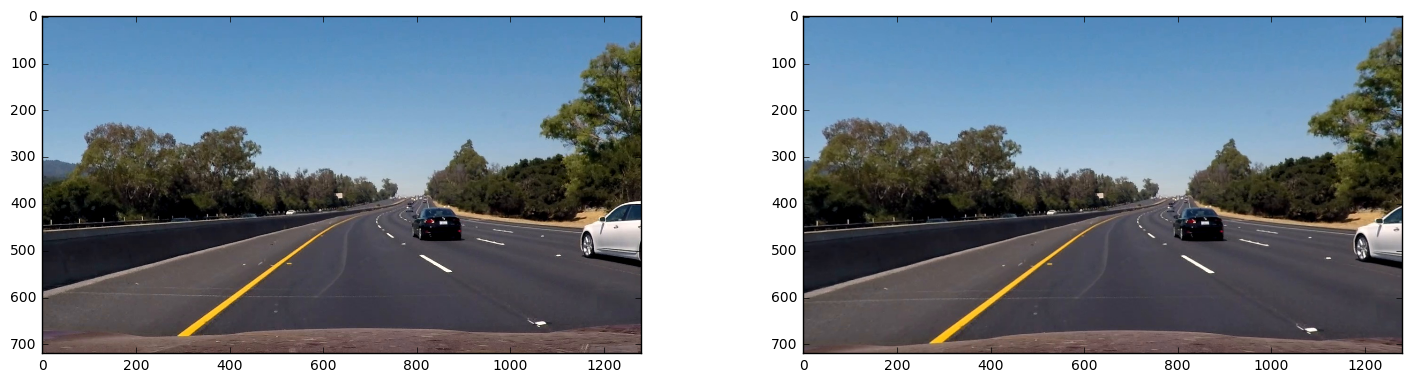

In [4]:
def undistort_image(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def display_image(image,result):
    fig = plt.figure(figsize=(18,20))
    a = fig.add_subplot(4,2,1)
    imgplot = plt.imshow(image,cmap='gray')
    a = fig.add_subplot(4,2,2)
    imgplot = plt.imshow(result,cmap='gray')
    plt.show()
    return None

def camera_calibration_test(mtx,dist):
    image = mpimg.imread('camera_cal/calibration1.jpg')
    undist_img  = undistort_image(image,mtx,dist)
    display_image(image, undist_img )

    image = mpimg.imread('test_images/test7.jpg')
    undist_img  = undistort_image(image,mtx,dist)
    display_image(image, undist_img )
    return None

if (1): mtx, dist = get_camera_calibration_values()
if (1): camera_calibration_test(mtx,dist)

## Histogram Equalization --> Color Balancing
Histogram Equalization is a great Computer Vision technique that improves contrast in images in order to stretch out the intensity range. This technique is especially useful when working with very dark or very bright images and greatly enhances filtering for particular colors and object detection.

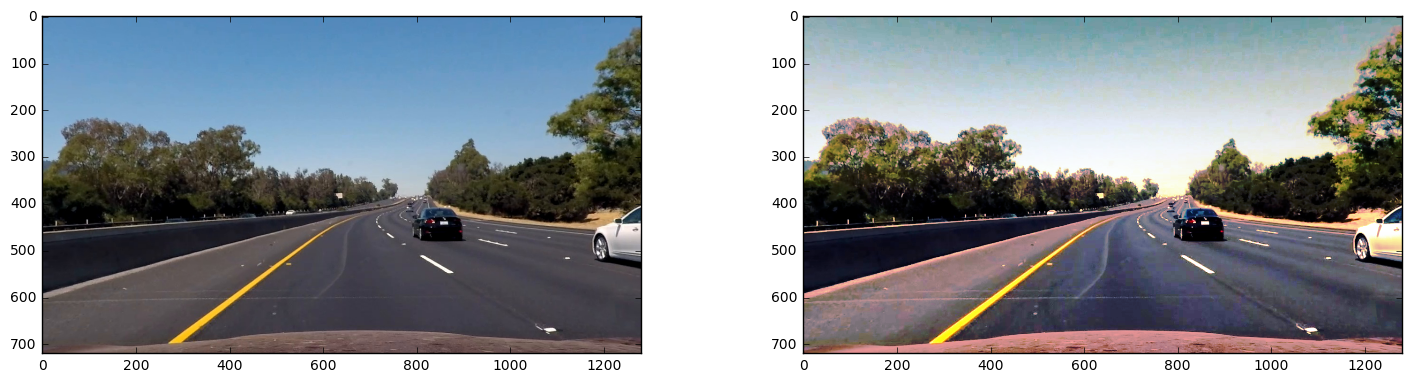

In [5]:
def histogram_equalize(img):
    r, g, b = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((red, green, blue))

def hist_equalization_test():
    image = mpimg.imread('test_images/test7.jpg')
    undist_img  = undistort_image(image,mtx,dist)    
    hist_eq = histogram_equalize(np.copy(undist_img))
    display_image(undist_img, hist_eq)

if (1): hist_equalization_test()

## Color Transforms --> Threshold Binary Image
This project uses color transforms to create a thresholded binary image. The primary goal for this project is to identify and track lane lines in a video stream. Traffic Lane Lines are either Yellow or White. These colors can often be easier to identify with multiple color spaces (RGB, HSV, HLS). Color Transforms into different color spaces was used along with thresholding values to filter for Yellow and White. Threshold Binary Images from multiple color spaces were then combined for pixel analysis.

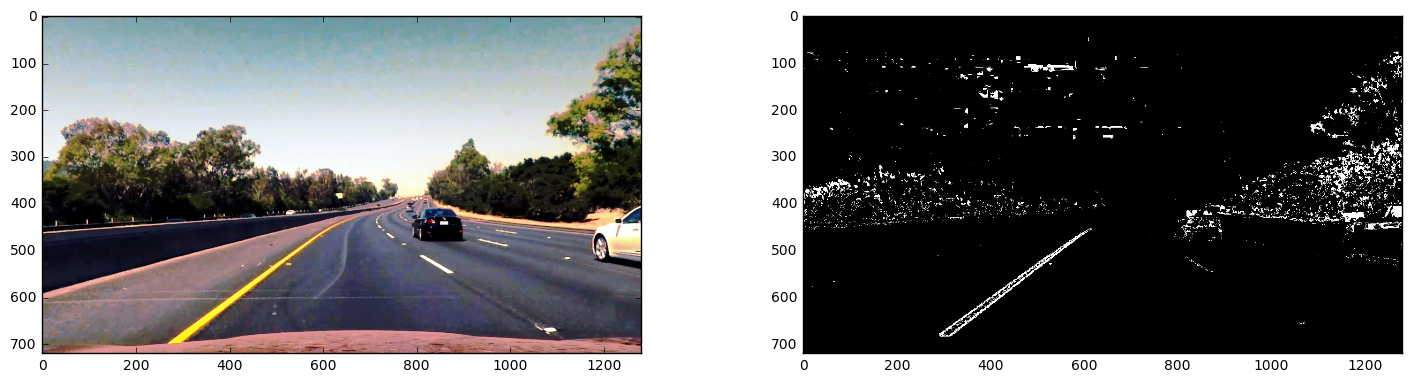

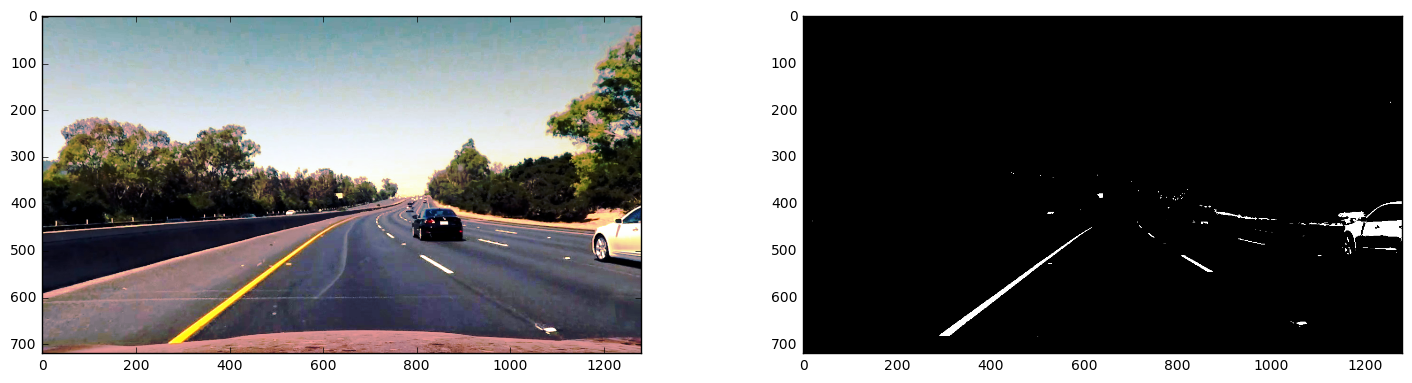

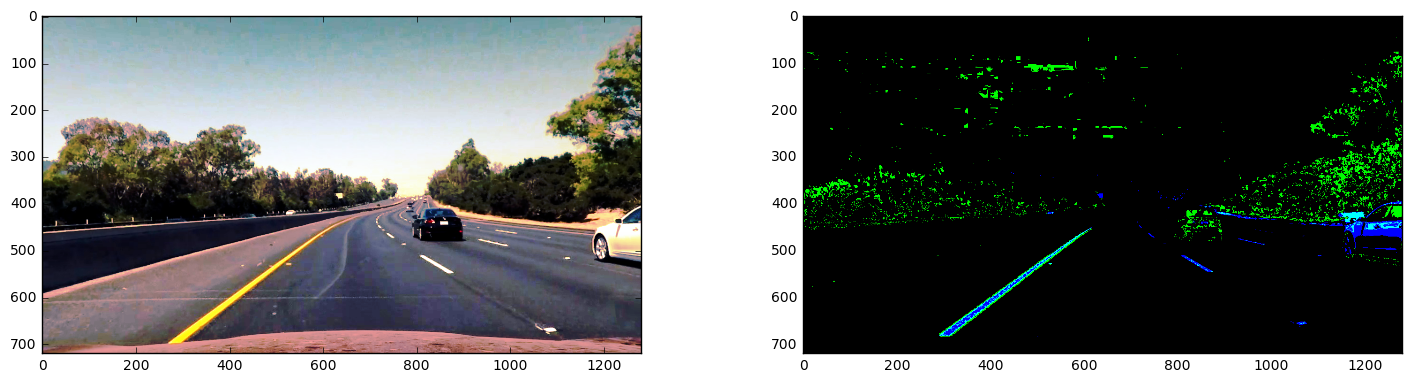

In [6]:
def s_color_thresh(img, sthresh=(120,250)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    return s_binary    

def r_color_thresh(img, rthresh=(200,255)):
    rgb = img
    r_channel = rgb[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= rthresh[0]) & (r_channel <= rthresh[1])] = 1
    return r_binary

def color_threshold(img, sthresh=(0,255), vthresh=(0,255), rthresh=(180,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    rgb = img
    r_channel = rgb[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= rthresh[0]) & (r_channel <= rthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[((s_binary == 1) & (v_binary == 1)) | (r_binary == 1)] = 1 
    return output*255

def color_threshold_test():
    image = mpimg.imread('test_images/test7.jpg')
    undist_img  = undistort_image(image,mtx,dist)    
    hist_eq = histogram_equalize(np.copy(undist_img))
    
    s_binary = s_color_thresh(image)
    display_image(hist_eq,s_binary)

    r_binary = r_color_thresh(image)
    display_image(hist_eq,r_binary)
    
    color_binary = np.dstack((np.zeros_like(r_binary),s_binary,r_binary))*255
    display_image(hist_eq,color_binary)
    
    return hist_eq, color_binary

if (1): hist_eq, color_binary = color_threshold_test()

## Perspective Transform --> Dynamic Warping
Lane Lines converge at the horizon in camera images, but in reality are parallel. Perspective Transforms take source points (src) on an image and maps those to destination (dst) on a warped image. This effectively transforms a forward looking camera image of the road into an overhead bird's eye view which makes lane identification much easier.

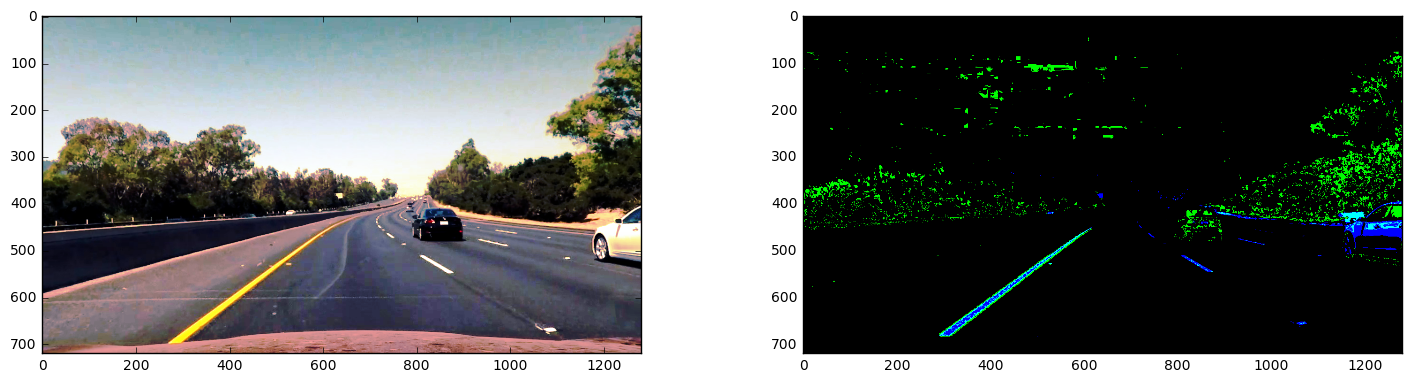

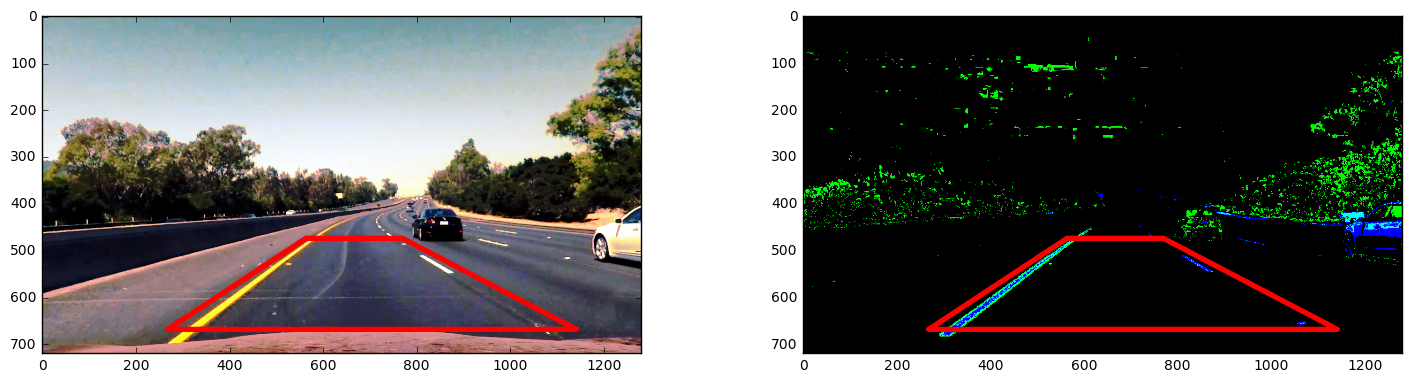

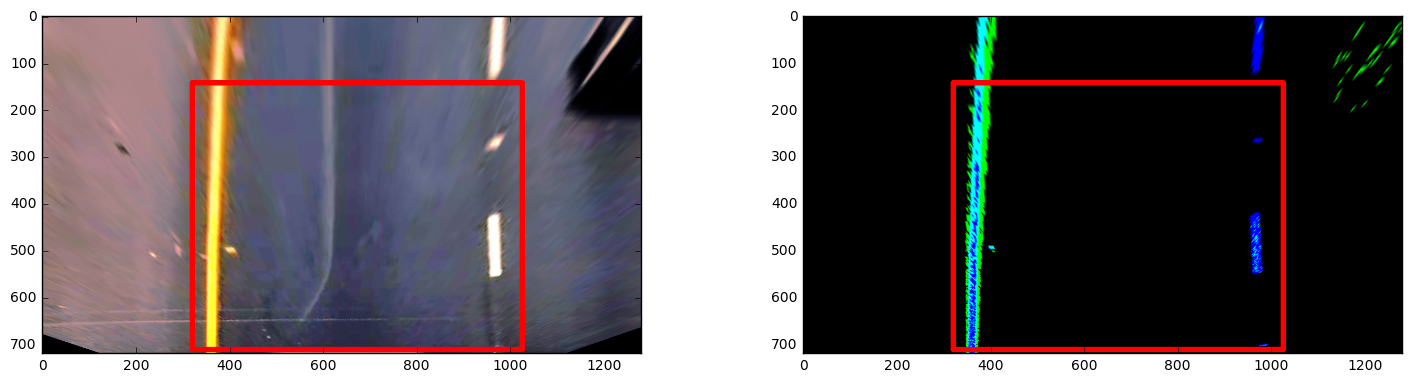

In [7]:
def perspective_transform(img,src,dst): # lane lines should appear parallel
    wd, ht = img.shape[1], img.shape[0]
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(np.copy(img), M, (wd,ht), flags=cv2.INTER_LINEAR)

    img_lines = draw_lines(np.copy(img),src)
    warped_lines = draw_lines(np.copy(warped),dst)
    return warped, img_lines, warped_lines

def draw_lines(img, src):
    thickness = 10
    p1, p2, p3, p4 = get_points(src)
    cv2.line(img, p1, p2, [255,0,0], thickness, cv2.LINE_AA)
    cv2.line(img, p2, p3, [255,0,0], thickness, cv2.LINE_AA)
    cv2.line(img, p3, p4, [255,0,0], thickness, cv2.LINE_AA)
    cv2.line(img, p4, p1, [255,0,0], thickness, cv2.LINE_AA)
    return img

def get_points(src):
    p1 = (int(src[0][0]), int(src[0][1]))
    p2 = (int(src[1][0]), int(src[1][1]))
    p3 = (int(src[2][0]), int(src[2][1]))
    p4 = (int(src[3][0]), int(src[3][1]))
    return p1, p2, p3, p4

def perspective_transform_test(img, color_binary):
    wd, ht = 1280, 720
    src = np.float32([[0.21*wd,0.93*ht],[0.44*wd,0.66*ht],[0.60*wd,0.66*ht],[0.89*wd,0.93*ht]]) 
    dst = np.float32([[0.25*wd,0.99*ht],[0.25*wd,0.20*ht],[0.80*wd,0.20*ht],[0.80*wd,0.99*ht]]) 
    
    _, img_lines, warped_lines = perspective_transform(np.copy(img),src,dst)
    _, img_lines_bin, warped_lines_bin = perspective_transform(np.copy(color_binary),src,dst)

    display_image(img, color_binary)
    display_image(img_lines, img_lines_bin)
    display_image(warped_lines, warped_lines_bin)

if (1): perspective_transform_test(hist_eq, color_binary)

## Detect Lane Pixels --> Draw Lane Boundary
The get window and cone lines function takes Thresholded Binary Images as inputs and then calls the get base for lane lines function. This next function calculates histograms to find the center of lane lines from within multiple sliding windows. The centers of these histograms are then used as inputs to the get lane line points function. This function uses np.linspace to calculate the polynomial that is used to create new points for drawing the lane boundaries on the original image.

In [8]:
def get_base_for_lane_lines(c_binary_left,c_binary_right):
    midpoint = np.int(c_binary_left.shape[1]/2)      
    hist_left = np.sum(c_binary_left[3*c_binary_left.shape[0]/4:,:], axis=0)     
    leftx_base = np.argmax(hist_left[:midpoint-50]) 
    hist_right = np.sum(c_binary_right[3*c_binary_right.shape[0]/4:,:], axis=0)     
    rightx_base = np.argmax(hist_right[midpoint+50:]) + midpoint 
    return hist_left, hist_right, leftx_base, rightx_base

def get_lane_line_points(img_ht,left_fit,right_fit):
    ploty = np.linspace(0, img_ht - 1, img_ht)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    return ploty, left_fitx, right_fitx

In [9]:
def plot_binary_points(out_img,nonzerox_left,nonzeroy_left,left_lane_inds,nonzerox_right,nonzeroy_right,right_lane_inds):
    out_img[nonzeroy_left[left_lane_inds], nonzerox_left[left_lane_inds]] = points_col  
    out_img[nonzeroy_right[right_lane_inds], nonzerox_right[right_lane_inds]] = points_col     
    return out_img

def draw_lane_lines(out_img,left_fitx,right_fitx,ploty):
    for i in range(len(left_fitx)-1):
        x1, y1 = int(left_fitx[i]), int(ploty[i])
        x2, y2 = int(left_fitx[i+1]), int(ploty[i+1])
        cv2.line(out_img, (x1,y1), (x2,y2), lane_col , 3, cv2.LINE_AA) 
        x1, y1 = int(right_fitx[i]), int(ploty[i])
        x2, y2 = int(right_fitx[i+1]), int(ploty[i+1])
        cv2.line(out_img, (x1,y1), (x2,y2), lane_col, 3, cv2.LINE_AA) 
    return out_img

def draw_cone(out_img,left_fitx,right_fitx,ploty):
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), cone_col) 
    cv2.fillPoly(window_img, np.int_([right_line_pts]), cone_col) 
    out_img = cv2.addWeighted(out_img, 1, window_img, 1.2, 0) # 0.3
    return out_img

def draw_polygon_lane(out_img,left_fit,right_fit):
    left_points_poly, right_points_poly = list(), list()
    for y in range(0,out_img.shape[0],4):
        left_points_poly.append((int(np.poly1d(left_fit)(y)), y))
        right_points_poly.append((int(np.poly1d(right_fit)(y)), y)) 
    poly_points = right_points_poly + list(reversed(left_points_poly)) 
    poly_image = cv2.fillPoly(out_img, np.array([[poly_points]]), polygon_col, cv2.LINE_AA)
    return out_img

## Exponential Smoothing --> Steady Images
Exponential Smoothing is very helpful with handling bouncing unsteady images from video streams. 

In [10]:
def exponential_smoothing(left_fit,right_fit,windows):
    global left_parms, right_parms
    if pic_count == 1 or not video: left_parms, right_parms = left_fit, right_fit
    
    #if not windows:
        #if pic_count >= 5: # checking for +- 3 sd's, if out of range then keep existing value
        #    left_fit, right_fit = hf.check_curve_boundaries(left_fit,right_fit,left_parms,right_parms)
      
    ''' only update when drawing cones '''
    if not windows: 
        if pic_count > 1: # update existing parms
            left_parms[0] = alpha_left * left_parms[0] + (1 - alpha_left) * left_fit[0]
            left_parms[1] = alpha_left * left_parms[1] + (1 - alpha_left) * left_fit[1]
            left_parms[2] = alpha_left * left_parms[2] + (1 - alpha_left) * left_fit[2]
        
            right_parms[0] = alpha_right * right_parms[0] + (1 - alpha_right) * right_fit[0]
            right_parms[1] = alpha_right * right_parms[1] + (1 - alpha_right) * right_fit[1]
            right_parms[2] = alpha_right * right_parms[2] + (1 - alpha_right) * right_fit[2]
        
    ''' resetting values for polygon '''
    if not windows: left_fit, right_fit = left_parms, right_parms
    return left_fit, right_fit

## Radius of Curvature --> Position of Vehicle
Radius of Curvature and Position of Vehicle are calculated in the get window and cone lines function. The code for this information is listed new the bottom of this function under the heading "get vehicle position and road curvature". These calculations should be moved to their own function in a future commit.

In [11]:
def get_window_and_cone_lines(img,c_binary_left,c_binary_right,windows):  
    wd, ht = img.shape[1], img.shape[0]
    window_height = np.int(ht / n_windows)
    out_img, left_lane_inds, right_lane_inds = np.zeros_like(img), [], []  
    
    nonzero_left, nonzero_right = c_binary_left.nonzero(), c_binary_right.nonzero()
    nonzeroy_left, nonzerox_left = np.array(nonzero_left[0]), np.array(nonzero_left[1])
    nonzeroy_right, nonzerox_right = np.array(nonzero_right[0]), np.array(nonzero_right[1])
    
    hist_left,hist_right,leftx_current,rightx_current = get_base_for_lane_lines(c_binary_left,c_binary_right)
    #display_hist(hist_left,hist_right) ### ADD PLOT TO DIAGSCREEN ###
    #return hist_left,hist_right,leftx_current,rightx_current
       
    ''' find lanes with windows '''    
    if windows:
        for window in range(n_windows):
            win_y_low, win_y_high = (ht - (window+1)*window_height), (ht - window*window_height)   
            win_xleft_low, win_xleft_high = (leftx_current - margin), (leftx_current + margin)
            win_xright_low, win_xright_high = (rightx_current - margin), (rightx_current + margin)     
            
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)       
            
            good_left_inds = ((nonzeroy_left >= win_y_low) & 
                              (nonzeroy_left < win_y_high) & 
                              (nonzerox_left >= win_xleft_low) & 
                              (nonzerox_left < win_xleft_high)).nonzero()[0]  
        
            good_right_inds = ((nonzeroy_right >= win_y_low) & 
                               (nonzeroy_right < win_y_high) & 
                               (nonzerox_right >= win_xright_low) & 
                               (nonzerox_right < win_xright_high)).nonzero()[0]
        
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            if len(good_left_inds) > minpix: leftx_current = \
                np.int(np.mean(nonzerox_left[good_left_inds]))
            if len(good_right_inds) > minpix: rightx_current = \
                np.int(np.mean(nonzerox_right[good_right_inds]))
            
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    ''' find lanes with cones '''    
    if not windows:    
        left_lane_inds = \
        ((nonzerox_left > (left_parms[0]*(nonzeroy_left**2) + 
                           left_parms[1]*nonzeroy_left + left_parms[2] - margin)) &
         
         (nonzerox_left < (left_parms[0]*(nonzeroy_left**2) + 
                           left_parms[1]*nonzeroy_left + left_parms[2] + margin))) 
    
        right_lane_inds = \
        ((nonzerox_right > (right_parms[0]*(nonzeroy_right**2) + 
                            right_parms[1]*nonzeroy_right + right_parms[2] - margin)) &
         
         (nonzerox_right < (right_parms[0]*(nonzeroy_right**2) + 
                            right_parms[1]*nonzeroy_right + right_parms[2] + margin)))         
        
    '''  update parms for lane lines '''
    leftx, lefty = nonzerox_left[left_lane_inds], nonzeroy_left[left_lane_inds] 
    if len(leftx) < minpix: left_fit = left_parms
    if len(leftx) >= minpix: left_fit = np.polyfit(lefty, leftx, 2)  
        
    rightx, righty = nonzerox_right[right_lane_inds], nonzeroy_right[right_lane_inds]        
    if len(rightx) < minpix: right_fit = right_parms
    if len(rightx) >= minpix: right_fit = np.polyfit(righty, rightx, 2)
        
    left_fit, right_fit = exponential_smoothing(left_fit,right_fit,windows)

    ''' display the results '''
    out_img = plot_binary_points(out_img,nonzerox_left,nonzeroy_left,left_lane_inds,
                                 nonzerox_right,nonzeroy_right,right_lane_inds) 
    
    ploty, left_fitx, right_fitx = get_lane_line_points(img.shape[0],left_fit,right_fit)   
    if windows: out_img = draw_lane_lines(out_img,left_fitx,right_fitx,ploty)
    if not windows: out_img = draw_cone(out_img,left_fitx,right_fitx,ploty)
    if not windows: out_img = draw_polygon_lane(out_img,left_fit,right_fit)        
    #if not windows: adaptive_warping(img,left_fitx,right_fitx,ploty) # update src for warping  
    
    ''' get vehicle position and road curvature '''
    res_yvals = np.arange(ht-(window_height/2),0,-window_height)
    curve_fit_cr = np.polyfit(np.array(ploty,np.float32)*ym_per_pix, \
                              np.array(left_fitx,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cr[0]*ploty[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) / \
                              np.absolute(2*curve_fit_cr[0])
    camera_center = (left_fitx[-1] + right_fitx[-1])/2 # calculate the offset of the car on the road
    center_diff = (camera_center-img.shape[1]/2)*xm_per_pix
    
    if center_diff > 0: side_pos = 'left'
    if center_diff <= 0: side_pos = 'right'
    
    return out_img,curverad,center_diff,side_pos

## Detect Lane Pixels --> Draw Lane Boundary (test images)
Sample Images for detecting lane pixels and drawing polynomial lane boundaries are shown below.

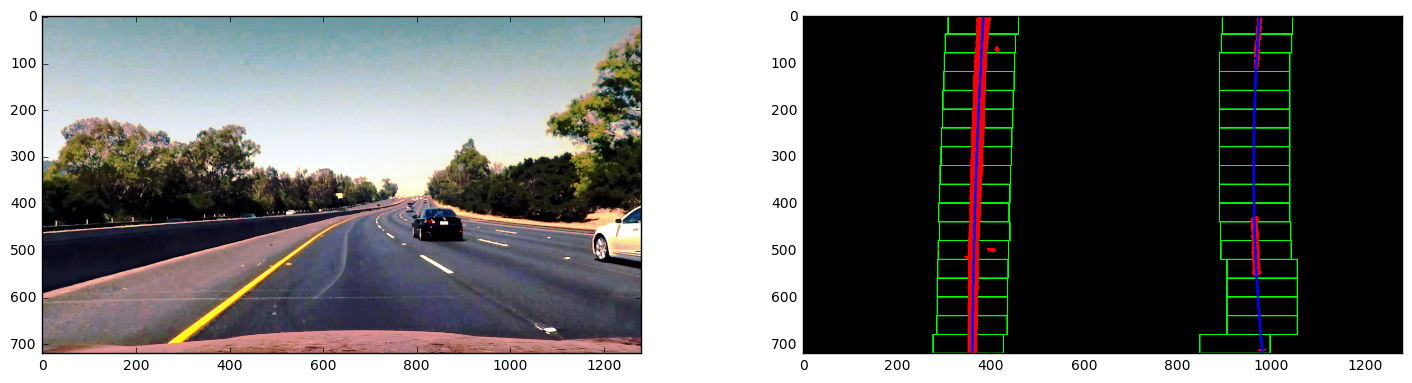

In [12]:
def find_pixel_lanes_test(img):
    undist_img = cv2.undistort(np.copy(img),mtx,dist,None,mtx)       
    hist_eq = histogram_equalize(np.copy(undist_img))   
    warped_img, img_lines, warped_lines = perspective_transform(np.copy(hist_eq),src,dst)
    
    c_binary_left = color_threshold(np.copy(warped_img), sthresh_left, vthresh_left, rthresh_left) 
    c_binary_right = color_threshold(np.copy(warped_img), sthresh_right, vthresh_right, rthresh_right) 
    
    out_img_win,curverad,center_diff,side_pos = get_window_and_cone_lines(img,c_binary_left,c_binary_right,True)
    out_img_cone,curverad,center_diff,side_pos = get_window_and_cone_lines(img,c_binary_left,c_binary_right,False)
    return hist_eq, out_img_win

wd, ht = 1280, 720
src = np.float32([[0.21*wd,0.93*ht],[0.44*wd,0.66*ht],[0.60*wd,0.66*ht],[0.89*wd,0.93*ht]]) 
dst = np.float32([[0.25*wd,0.99*ht],[0.25*wd,0.20*ht],[0.80*wd,0.20*ht],[0.80*wd,0.99*ht]]) 

sthresh_left, sthresh_right = (255,255), (255,255)
vthresh_left, vthresh_right = (255,255), (255,255)
rthresh_left, rthresh_right = (235,255), (254,255)

n_windows = 18
margin = 75
minpix = 50
#warp_height = 540
bright_lanes = False
polygon_col = [0,255,0] 
#alpha_left, alpha_right = 0.90, 0.90
pic_count, video = 0, True
xm_per_pix, ym_per_pix = 4/384, 10/720
left_parms, right_parms = np.array([0,0,0]), np.array([0,0,0])
points_col, lane_col, cone_col = [255,0,0], [0,0,255], [0,0,255]

def pipeline_test():
    image = mpimg.imread('test_images/test7.jpg')
    img1, img2 = find_pixel_lanes_test(image)
    display_image(img1,img2)
    return None
  
if (1): pipeline_test()

## Display Visuals --> Save Output Images

In [13]:
def get_brightness(img,hist_eq):
    bright_road = np.mean(img[0.66*img.shape[0]:,:])
    brighteq_road = np.mean(hist_eq[0.66*img.shape[0]:,:])
    return bright_road, brighteq_road

def get_dark_level(brightness):
    if brightness < 51: return 'very dark: underexposed'
    if brightness < 102: return 'dark'
    if brightness < 153: return 'medium'
    if brightness < 204: return 'light'
    if brightness < 255: return 'very light: overexposed'

In [14]:
def diagnostic_view(img_list):
    height, width = 1080, 1920
    diagScreen = np.zeros((height, width, 3), dtype=np.uint8)

    diag0 = img_list[0] #cv2.cvtColor(img_list[0], cv2.COLOR_RGB2BGR)
    diag1 = img_list[1] #cv2.cvtColor(img_list[1], cv2.COLOR_RGB2BGR)
    diag2 = img_list[2] #cv2.cvtColor(img_list[2], cv2.COLOR_RGB2BGR)
    diag3 = np.dstack((img_list[3],img_list[3],img_list[3]))
    diag4 = np.dstack((img_list[4],img_list[4],img_list[4]))
    #diag3 = cv2.cvtColor(diag3, cv2.COLOR_RGB2BGR)
    #diag4 = cv2.cvtColor(diag4, cv2.COLOR_RGB2BGR)
    diag5 = cv2.cvtColor(img_list[5], cv2.COLOR_RGB2BGR)
    #diag6 = cv2.cvtColor(img_list[6], cv2.COLOR_RGB2BGR)
    diag6 = img_list[6]
    diag7 = cv2.cvtColor(img_list[7], cv2.COLOR_RGB2BGR)
    diag8 = img_list[8]
    diag9 = img_list[9]
    diag10 = img_list[10]
    diag11 = img_list[11]
        
    diagScreen[0:540,0:960] = cv2.resize(diag9, (960,540), interpolation=cv2.INTER_AREA)    
    diagScreen[0:270,960:1440] = cv2.resize(diag1, (480,270), interpolation=cv2.INTER_AREA)
    diagScreen[0:270,1440:1920] = cv2.resize(diag2, (480,270), interpolation=cv2.INTER_AREA)
    diagScreen[270:540,960:1440] = cv2.resize(diag3, (480,270), interpolation=cv2.INTER_AREA)
    diagScreen[270:540,1440:1920] = cv2.resize(diag4, (480,270), interpolation=cv2.INTER_AREA)
    diagScreen[540:810,960:1440] = cv2.resize(diag5, (480,270), interpolation=cv2.INTER_AREA)
    diagScreen[540:810,1440:1920] = cv2.resize(diag6, (480,270), interpolation=cv2.INTER_AREA)
    diagScreen[810:1080,960:1440] = cv2.resize(diag7, (480,270), interpolation=cv2.INTER_AREA)
    diagScreen[810:1080,1440:1920] = cv2.resize(diag8, (480,270), interpolation=cv2.INTER_AREA)
    #diagScreen[540:1080,0:960] = cv2.resize(diag0, (960,540), interpolation=cv2.INTER_AREA)
    diagScreen[540:810,0:480] = cv2.resize(diag10, (480,270), interpolation=cv2.INTER_AREA)
    diagScreen[540:810,480:960] = cv2.resize(diag11, (480,270), interpolation=cv2.INTER_AREA)
    return diagScreen

In [15]:
def save_output_pics(video_dir,pic_count,img,output_img):
    if output_img: outfile = 'output_images/' + video_dir + '/' + video_dir + '_' + str(pic_count) + '.jpg'
    else: outfile = 'input_images/' + video_dir + '/' + video_dir + '_' + str(pic_count) + '.jpg'
    result = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(outfile, result)
    return None

## Image Pipeline

In [16]:
def pipeline(img):
    undist_img = cv2.undistort(np.copy(img),mtx,dist,None,mtx)       
    hist_eq = histogram_equalize(np.copy(undist_img))   
    warped_img, img_lines, warped_lines = perspective_transform(np.copy(hist_eq),src,dst)
    #return warped_lines
    
    c_binary_left = color_threshold(np.copy(warped_img), sthresh_left, vthresh_left, rthresh_left) 
    c_binary_right = color_threshold(np.copy(warped_img), sthresh_right, vthresh_right, rthresh_right) 
    #return c_binary_left, c_binary_right
    
    out_img_win,curverad,center_diff,side_pos = get_window_and_cone_lines(img,c_binary_left,c_binary_right,True)
    out_img_cone,curverad,center_diff,side_pos = get_window_and_cone_lines(img,c_binary_left,c_binary_right,False)
    #return out_img_win, out_img_cone
    
    warped_win, img_lines1, warped_lines1 = perspective_transform(np.copy(out_img_win),dst,src)
    warped_cone, img_lines2, warped_lines2 = perspective_transform(np.copy(out_img_cone),dst,src)
       
    if bright_lanes:
        road_bkg = np.zeros_like(warped_cone)
        road_bkg[(warped_cone[:,:,0] > 0) | (warped_cone[:,:,1] > 0) | (warped_cone[:,:,2] > 0)] = [255,255,255]
        base = cv2.addWeighted(undist_img, 1.0, road_bkg, -1.0, 0.0)
        result = cv2.addWeighted(base, 1.0, warped_cone, 1.0, 0.0)    
        
    if not bright_lanes: result = cv2.addWeighted(undist_img, 1, warped_cone, 1.6, 0) # 0.3
    #return result  
    
    font = cv2.FONT_HERSHEY_SIMPLEX   
    text = 'Frame Number: ' + str(pic_count)
    cv2.putText(result, text, (50,50), font, 1, (0,255,0), 2, cv2.LINE_AA)  
    text = 'Radius of Curvature = '+str(round(curverad,3))+'(m)'
    cv2.putText(result,text,(50,100),font,1,(255,255,255),2, cv2.LINE_AA)
    text = 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center '
    cv2.putText(result,text,(50,150),font, 1, (255,255,255),2, cv2.LINE_AA)
    bright_road, brighteq_road = get_brightness(undist_img, hist_eq)
    text = 'Road Brightness: ' + get_dark_level(bright_road)
    cv2.putText(result, text, (50,200), font, 1.0, (255,255,255), 2, cv2.LINE_AA) 
    text = 'Road Brightness: ' + get_dark_level(brighteq_road) + ' (balanced)'
    cv2.putText(result, text, (50,250), font, 1.0, (255,255,255), 2, cv2.LINE_AA)
        
    result, out_img, heatmap, heat_parms = P5.final_pipeline_merge(undist_img, result)
    fillmap = np.zeros_like(heatmap)
    heatmap = np.dstack((heatmap,fillmap,fillmap))*255
    
    heatmap = cv2.addWeighted(undist_img, 1, heatmap, 3.2, 0) # 1.6
    #print (np.mean(heatmap), heatmap.shape, img.shape)
    #plt.imshow(heatmap)
    #plt.show()
    
    diagScreen = diagnostic_view([undist_img,img_lines,warped_lines,
                 c_binary_left,c_binary_right,out_img_win,out_img_cone,
                 warped_win,warped_cone,result,out_img,heatmap])    
      
    return diagScreen

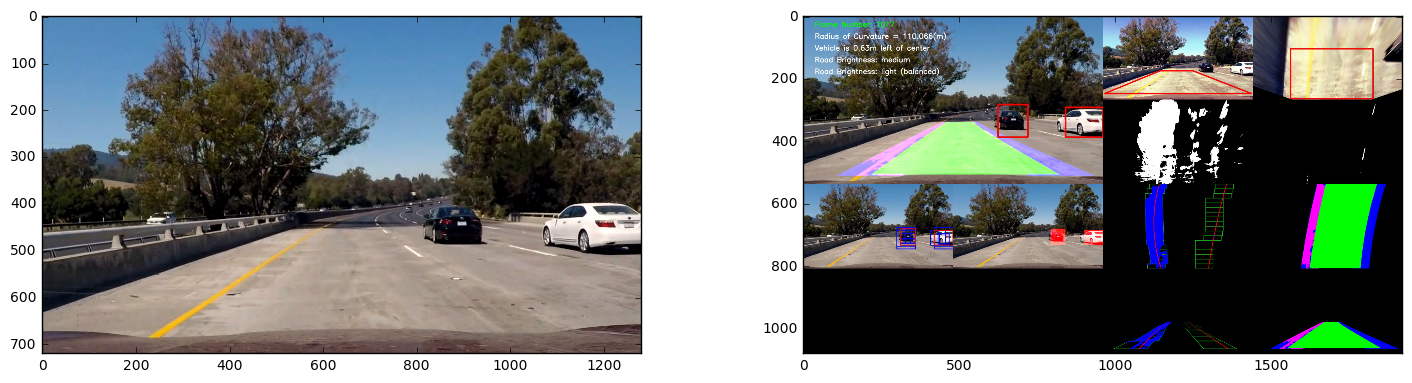

In [20]:
wd, ht = 1280, 720
src = np.float32([[0.21*wd,0.93*ht],[0.44*wd,0.66*ht],[0.60*wd,0.66*ht],[0.89*wd,0.93*ht]]) 
dst = np.float32([[0.25*wd,0.99*ht],[0.25*wd,0.20*ht],[0.80*wd,0.20*ht],[0.80*wd,0.99*ht]]) 

sthresh_left, sthresh_right = (255,255), (255,255)
vthresh_left, vthresh_right = (255,255), (255,255)
rthresh_left, rthresh_right = (235,255), (254,255)

n_windows = 18
margin = 75
minpix = 50
#warp_height = 540
bright_lanes = False
polygon_col = [0,255,0] 
#alpha_left, alpha_right = 0.90, 0.90
pic_count, video = 0, True
xm_per_pix, ym_per_pix = 4/384, 10/720
left_parms, right_parms = np.array([0,0,0]), np.array([0,0,0])
points_col, lane_col, cone_col = [255,0,0], [0,0,255], [0,0,255]

def pipeline_test():
    image = mpimg.imread('test_images/test1017.jpg')
    result = pipeline(image)
    display_image(image, result)
    return None
  
if (1): pipeline_test()

## Video Pipeline
Project 4: Advanced Lane Finding, [Video Pipeline Result](https://youtu.be/b2WBX3jGyy4)

In [18]:
def process_image(img):
    global pic_count
    pic_count += 1
    
    if img.shape[0] != 720 or img.shape[1] != 1280: 
        img = cv2.resize(img, (1280,720), interpolation=cv2.INTER_AREA) 
        
    result = pipeline(img)
    save_output_pics(video_dir,pic_count,result,True)
    
    return result

In [22]:
wd, ht = 1280, 720
pic_count, video = 0, True
xm_per_pix, ym_per_pix = 4/384, 10/720
sthresh_left, sthresh_right = (255,255), (255,255)
vthresh_left, vthresh_right = (255,255), (255,255)
left_parms, right_parms = np.array([0,0,0]), np.array([0,0,0])
points_col, lane_col, cone_col = [255,0,0], [0,0,255], [0,0,255]
dst = np.float32([[0.25*wd,0.99*ht],[0.25*wd,0.20*ht],[0.80*wd,0.20*ht],[0.80*wd,0.99*ht]])

videos = ['video_4', 'video_5', 'video_6', 'video_7', 'video_8']       
    
def test_videos(video):
    clip = VideoFileClip(video+'.mp4')
    video_output = video+'_output.mp4'
    video_clip = clip.fl_image(process_image)
    %time video_clip.write_videofile(video_output, audio=False)
    #hf.plot_brightness()
    #hf.plot_curve_data()
    return video_output

if video_idx == 0:
    n_windows = 18
    margin = 75
    minpix = 50
    #warp_height = 540
    bright_lanes = False
    polygon_col = [0,255,0] 
    alpha_left, alpha_right = 0.90, 0.90
    rthresh_left, rthresh_right = (235,255), (254,255)
    src = np.float32([[0.01*wd,0.93*ht],[0.38*wd,0.66*ht],[0.60*wd,0.66*ht],[0.99*wd,0.93*ht]]) 
    dst = np.float32([[0.25*wd,0.99*ht],[0.25*wd,0.40*ht],[0.80*wd,0.40*ht],[0.80*wd,0.99*ht]])    

if video_idx == 1:
    n_windows = 18
    margin = 40
    minpix = 50
    #warp_height = 475
    bright_lanes = True
    polygon_col = [0,255,0] 
    alpha_left, alpha_right = 0.95, 0.90
    rthresh_left, rthresh_right = (200,255), (235,255)
    src = np.float32([[0.01*wd,0.93*ht],[0.43*wd,0.66*ht],[0.60*wd,0.66*ht],[0.99*wd,0.93*ht]]) 
    dst = np.float32([[0.25*wd,0.99*ht],[0.25*wd,0.40*ht],[0.80*wd,0.40*ht],[0.80*wd,0.99*ht]])

if video_idx == 2:
    n_windows = 36
    margin = 40
    minpix = 50
    #warp_height = 540
    bright_lanes = False
    polygon_col = [255,153,0] 
    alpha_left, alpha_right = 0.90, 0.90
    rthresh_left, rthresh_right = (254,255), (254,255)
    src = np.float32([[0.01*wd,0.93*ht],[0.38*wd,0.72*ht],[0.60*wd,0.72*ht],[0.99*wd,0.93*ht]])
    dst = np.float32([[0.25*wd,0.99*ht],[0.25*wd,0.40*ht],[0.80*wd,0.40*ht],[0.80*wd,0.99*ht]])
    
if video_idx == 3:
    n_windows = 18
    margin = 40
    minpix = 50
    #warp_height = 540
    bright_lanes = True
    polygon_col = [255,153,0] 
    alpha_left, alpha_right = 0.90, 0.90
    rthresh_left, rthresh_right = (254,255), (254,255)
    src = np.float32([[-0.19*wd,0.97*ht],[0.28*wd,0.66*ht],[0.45*wd,0.66*ht],[0.79*wd,0.97*ht]])
    dst = np.float32([[0.25*wd,0.99*ht],[0.25*wd,0.40*ht],[0.80*wd,0.40*ht],[0.80*wd,0.99*ht]])
    
if video_idx == 4:
    n_windows = 18
    margin = 40
    minpix = 50
    #warp_height = 540
    bright_lanes = True
    polygon_col = [255,153,0] 
    alpha_left, alpha_right = 0.95, 0.90
    rthresh_left, rthresh_right = (254,255), (254,255)
    src = np.float32([[-0.19*wd,0.97*ht],[0.23*wd,0.66*ht],[0.45*wd,0.66*ht],[0.79*wd,0.97*ht]]) 
    dst = np.float32([[0.25*wd,0.99*ht],[0.25*wd,0.30*ht],[0.80*wd,0.30*ht],[0.80*wd,0.99*ht]])

## Project Video

In [19]:
video_idx = 0 # need video_idx == 3, 4

video_dir = videos[video_idx]
video_output = test_videos(video_dir)
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(video_output))

[MoviePy] >>>> Building video video_4_output.mp4
[MoviePy] Writing video video_4_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [24:55<00:01,  1.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_4_output.mp4 

Wall time: 24min 58s


## Challenge Video

In [21]:
video_idx = 1 # need video_idx == 3, 4   

video_dir = videos[video_idx]
video_output = test_videos(video_dir)
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(video_output))

[MoviePy] >>>> Building video video_5_output.mp4
[MoviePy] Writing video video_5_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [09:19<00:00,  1.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_5_output.mp4 

Wall time: 9min 20s


## Discussion
The biggest challenge was finding the right color thresholds to detect both yellow and white lines. Histogram Equalization helps immensely with balancing colors to detect lane lines in both dark and bright conditions. Selecting independent color thresholds for each lane line (left and right) was very helpful for optimizing towards yellow or white depending on the situation. Using independent alpha values to exponentially smooth each lane line (left and right) was also very helpful.

One particularly interesting function that was implemented in an early version of this project was using Adaptive Warping. Instead of using static values for source and destination perspective transformation, this function would use points on the lane line found in a bird’s eye view to use as the source points for the next image analysis. This Adaptive Warping worked very well in the first 150 frames for the Harder Challenge Video. 

One possible improvement for future implementation would be a Color Windowing search process. This function could scan each color space in small blocks while searching for the region that yields the best pixilation for lane finding. The Harder Challenge video has images where even Histogram Equalization is not helpful. These images are either very dark shadows casted by tall pine trees in the forest or extra bright washed out frames from over exposure. I think a Color Windowing function would be very useful for this type of driving condition. 

Other possible improvements would include Gradient Thresholds, Deep Learning and C++ for speed.

I’m very happy with the results of this project.